# Allen–Cahn Steady States with Neumann/periodic BC (Continuation)

This notebook demonstrates how to find steady-state solutions to the 1D Allen–Cahn equation with Neumann boundary conditions. The primary technique used is **pseudo-arclength continuation**, which allows us to trace out branches of solutions as a parameter is varied. This is particularly useful for navigating turning points (folds) in the bifurcation diagram where simpler continuation methods would fail.

The equation is given by:
$$ \varepsilon^2 u_{xx} + \mu u - u^3 = 0, \quad u_x(0)=u_x(L)=0. $$

### Section 1: Imports
We begin by importing the necessary libraries. `numpy` is for numerical operations, `scipy.sparse` for efficient representation of the discretized Laplacian, and `matplotlib` for plotting the results.

In [23]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (7, 4), "axes.grid": True})

### Section 2: Parameters and Grid
Here, we define the physical and numerical parameters for the simulation. 
- `L`: The length of the spatial domain.
- `N`: The number of grid points for the finite difference discretization.
- `epsilon`: A parameter that controls the width of the transition layers in the solution.
- `mu_crit`: The critical value of the bifurcation parameter $\mu$ where the trivial solution $u=0$ loses stability.

In [24]:
L = 1.0
N = 401  # grid points including boundaries
x = np.linspace(0.0, L, N)
h = x[1] - x[0]

epsilon = 0.03
eps2 = epsilon**2
mu_crit = eps2 * (np.pi / L) ** 2  # first Neumann mode bifurcation of u=0

forward_continuation = True  # set to True for forward continuation

if forward_continuation:
    # Forward continuation
    mu_start = mu_crit + 1e-4
    mu_end = 0.2
    mu_step = 1e-4
else:
    # Backward continuation
    mu_start = mu_crit + 1e-2
    mu_end = 0.0
    mu_step = -1e-6

The `l2_norm` function is a helper to compute the discrete $L^2$ norm of a solution, which will be used to plot the bifurcation diagram.

In [25]:
def l2_norm(u):
    return np.sqrt(np.mean(u**2))

### Section 3: Laplacian with Neumann BC and Nonlinear Term
We define a function `laplacian_neumann` to construct the finite difference matrix for the second derivative operator with zero Neumann boundary conditions. The nonlinear part of the equation, $u^3$, is also defined as a separate function.

In [26]:
def laplacian_neumann(n, h):
    """Constructs a sparse finite-difference Laplacian matrix with Neumann BC."""
    main = -2.0 * np.ones(n)
    off = 1.0 * np.ones(n - 1)
    data = [off, main, off]
    offsets = [-1, 0, 1]
    Lmat = sp.diags(data, offsets, shape=(n, n), format="lil")
    Lmat[0, 1] = 2.0
    Lmat[-1, -2] = 2.0
    return Lmat.tocsc() / h**2

Lap = laplacian_neumann(N, h)

def nonlinear(u):
    """Computes the nonlinear term of the Allen-Cahn equation."""
    return u**3

### Section 4: Residual and Jacobian
For the Newton's method solver, we need to define the residual of the discretized equation, $R(u, \mu) = \varepsilon^2 L u + \mu u - u^3$, and its Jacobian matrix, $J(u, \mu) = \varepsilon^2 L + \mu I - 3 \text{diag}(u^2)$.

In [27]:
def residual(u, mu):
    """Computes the residual of the discretized Allen-Cahn equation."""
    return eps2 * (Lap @ u) + mu * u - nonlinear(u)

def jacobian(u, mu):
    """Computes the Jacobian of the residual with respect to u."""
    diag = mu - (3.0 * u**2)
    return eps2 * Lap + sp.diags(diag, format="csc")

### Section 5: Newton Solver
This section implements a standard Newton's method with a backtracking line search to solve the nonlinear system $R(u, \mu) = 0$ for a fixed value of $\mu$. The line search helps to ensure convergence even when the initial guess is not very close to the solution.

In [28]:
def newton_solve(u0, mu, tol=1e-10, max_iter=30, ls_beta=0.5, ls_c=1e-4):
    """Solves the nonlinear system using Newton's method with line search."""
    u = u0.copy()
    res = residual(u, mu)
    res_norm = np.linalg.norm(res, ord=np.inf)
    history = [res_norm]

    for _ in range(max_iter):
        if res_norm < tol:
            return u, True, history

        J = jacobian(u, mu)
        try:
            du = spla.spsolve(J, -res)
        except Exception:
            return u, False, history

        step = 1.0
        accepted = False
        while step > 1e-6:
            u_trial = u + step * du
            r_trial = residual(u_trial, mu)
            r_norm = np.linalg.norm(r_trial, ord=np.inf)
            if r_norm <= (1 - ls_c * step) * res_norm:
                u, res, res_norm = u_trial, r_trial, r_norm
                history.append(res_norm)
                accepted = True
                break
            step *= ls_beta

        if not accepted:
            return u, False, history

    return u, res_norm < tol, history

### Section 6: Simple Predictor-Corrector Continuation in $\mu$
This is the core of the notebook. The `continuation` function implements a predictor-corrector scheme to trace the solution branch. 
- **Predictor**: A simple secant predictor is used. Given two previous solutions, it extrapolates to find an initial guess for the next solution.
- **Corrector**: The Newton solver from the previous section is used to correct the predicted solution.

In [29]:
def continuation(mu0=mu_start, mu_end=mu_end, step=mu_step, tol=1e-10):
    """Performs predictor-corrector continuation in the parameter mu."""
    solutions = []
    mus = []
    newton_iters = []
    l2_vals = []

    # seed with small first Neumann mode to land on patterned branch
    rng = np.random.default_rng(0)
    mode1 = np.cos(np.pi * x / L)
    u0 = 0.05 * mode1 + 0.01 * rng.standard_normal(N)
    u, ok, hist = newton_solve(u0, mu0, tol=tol)
    if not ok:
        raise RuntimeError("Failed to converge initial solve at mu0")
    solutions.append(u)
    mus.append(mu0)
    newton_iters.append(len(hist) - 1)
    l2_vals.append(l2_norm(u))

    mu = mu0
    direction = np.sign(mu_end - mu0) if mu_end != mu0 else 1.0
    step = abs(step) * direction

    while (mu - mu_end) * direction < -1e-12:
        mu_next = mu + step
        if (mu_next - mu_end) * direction > 0:
            mu_next = mu_end

        if len(solutions) >= 2:
            denom = max(mus[-1] - mus[-2], 1e-8)
            pred = solutions[-1] + (mu_next - mus[-1]) * (solutions[-1] - solutions[-2]) / denom
            guess = pred
        else:
            guess = solutions[-1]

        u_next, ok, hist = newton_solve(guess, mu_next, tol=tol)
        if not ok:
            step *= 0.5
            if abs(step) < 1e-4:
                break
            continue

        solutions.append(u_next)
        mus.append(mu_next)
        newton_iters.append(len(hist) - 1)
        l2_vals.append(l2_norm(u_next))

        if len(hist) <= 6 and abs(step) < 0.2:
            step = min(abs(step) * 1.2, 0.2) * direction

        mu = mu_next

    return {"mu": np.array(mus), "solutions": solutions, "newton_iters": np.array(newton_iters), "l2": np.array(l2_vals)}

In [30]:
cont = continuation()
print(f"Continuation reached mu = {cont['mu'][-1]:.3f} with {len(cont['mu'])} steps")
print(f"Newton iterations per step: min {cont['newton_iters'].min()}, max {cont['newton_iters'].max()}")

Continuation reached mu = 0.200 with 34 steps
Newton iterations per step: min 2, max 7


### Section 6.1: Why Continuation is Needed
This section demonstrates why continuation is often necessary. We attempt to find a non-trivial solution by starting Newton's method with a zero initial guess far from the bifurcation point. As shown, this approach converges to the trivial (zero) solution, failing to find the interesting patterned state. Continuation, by taking small steps, allows us to stay on the non-trivial solution branch.

Direct Newton from flat guess at mu=0.20: ok=True, iterations=0, ||u||_2=0.000
Continuation solution at same mu: ||u||_2=0.403


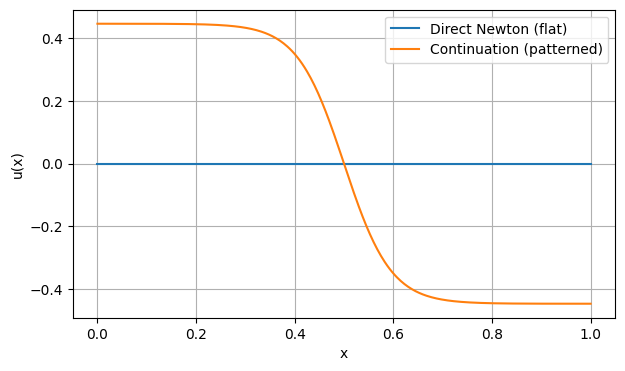

In [31]:
mu_demo = mu_end
u_flat = np.zeros(N)
u_direct, ok_direct, hist_direct = newton_solve(u_flat, mu_demo, tol=1e-10)
print(f"Direct Newton from flat guess at mu={mu_demo:.2f}: ok={ok_direct}, iterations={len(hist_direct)-1}, ||u||_2={l2_norm(u_direct):.3f}")

u_cont = cont["solutions"][-1]
print(f"Continuation solution at same mu: ||u||_2={l2_norm(u_cont):.3f}")

fig, ax = plt.subplots()
ax.plot(x, u_direct, label="Direct Newton (flat)")
ax.plot(x, u_cont, label="Continuation (patterned)")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend()
plt.show()

### Section 7: Visualize Branch and Profiles
Here, we plot the bifurcation diagram, which shows the $L^2$ norm of the solution as a function of the parameter $\mu$. We also visualize the solution profiles at several points along the branch.

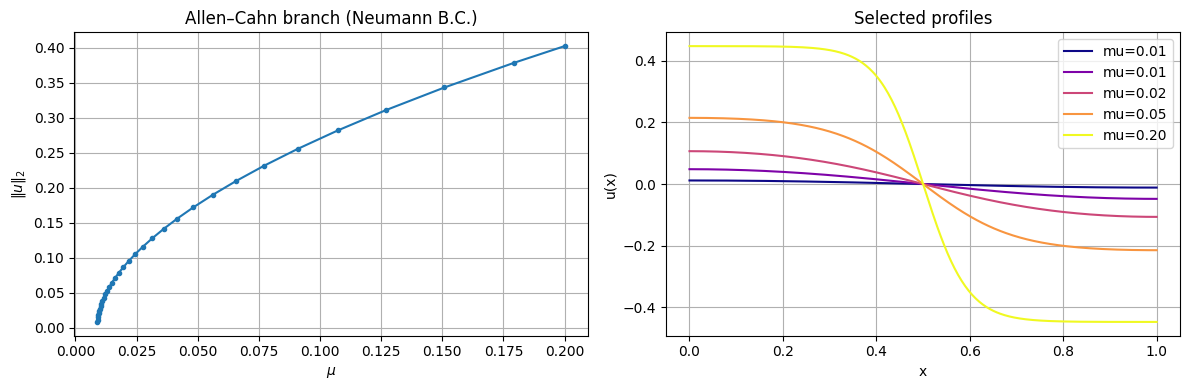

In [32]:
mus = cont["mu"]
branch = cont["l2"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(mus, branch, marker="o", ms=3)
axes[0].set_xlabel(r"$\mu$")
axes[0].set_ylabel(r"$\|u\|_2$")
axes[0].set_title("Allen–Cahn branch (Neumann B.C.)")

pick_idx = np.linspace(0, len(mus) - 1, 5, dtype=int)
colors = plt.cm.plasma(np.linspace(0, 1, len(pick_idx)))
for idx, c in zip(pick_idx, colors):
    u_full = cont["solutions"][idx]
    axes[1].plot(x, u_full, color=c, label=f"mu={mus[idx]:.2f}")

axes[1].set_xlabel("x")
axes[1].set_ylabel("u(x)")
axes[1].set_title("Selected profiles")
axes[1].legend()
plt.tight_layout()
plt.show()

### Section 8: Optional Time-Stepping Check
As a final check, we can take a steady-state solution from the continuation, perturb it slightly, and evolve it in time using the time-dependent Allen-Cahn equation. If the solution is stable, it should relax back to the original steady state. A semi-implicit Euler scheme is used for this time evolution.

In [33]:
def time_step(u0, mu, dt=5e-4, steps=500):
    """Performs time-stepping for the Allen-Cahn equation."""
    A = sp.eye(N, format="csc") - dt * eps2 * Lap
    rhs_u = u0.copy()
    u = u0.copy()
    for _ in range(steps):
        rhs = u + dt * (mu * u - nonlinear(u))
        u = spla.spsolve(A, rhs)
    return u

# Quick stability check from a perturbed steady state at the final mu
u_ss = cont["solutions"][-1]
pert = 0.05 * np.random.default_rng(0).standard_normal(N)
u_pert = u_ss + pert
u_relaxed = time_step(u_pert, mus[-1], dt=1e-3, steps=300)
print(f"Time-stepping check: ||u_relaxed - u_ss||_inf = {np.linalg.norm(u_relaxed - u_ss, ord=np.inf):.2e}")

Time-stepping check: ||u_relaxed - u_ss||_inf = 1.69e-02
